Переразмечаем данные 
в результрующем наборе оставляем скважины, где уверенно выделяем интервалы начала 7 фации

присваемем столбцу фаций значение 3
бъем все данные на сквыажины
пробигаемся по всем скважинам, добавляем и удаляем признаки
    добавлем полосы билинджера по GR
    удаляем sp, bk, nktb, lit, layer,
    Добавляем лаг по GR. или полосам билинджера
пробигаемся по скважинам
    если скважина интересная для разметки то меняем в коткретном диапазоне скважины

собираем всё вместе и предсказываем значения фаций

потом визуализируем скважины, где была предсказанна 7 фация

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
import talib, math
%matplotlib inline

In [132]:


def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 2000]
    return feature

def get_for_learn_clean_df_spk1799PL(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    feature = feature[feature['wellName'] == 'spk1799PL']
    feature = feature[feature["MD"] > 2000]
    feature = feature[feature["MD"] * 10 % 2 > 0.001]
    feature['wellName'] = 'spk1799PL_shift'
    return feature

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

def change_undefined(x):
    undefined_value = -1
    if x == 'NaN':
        return undefined_value
    if math.isnan(x):
        return undefined_value
    if math.isinf(x):
        return undefined_value
    if x < -1:
        return undefined_value
    return x

def change_facies(x):
    undefined_value = -9999
    if x == 7:
        return x
    return 3
    if x > -1:
        return 3
    return x

for_ml = get_for_learn_clean_df(pd.read_csv('Correct_train_26.csv', sep=';'))
spk1799PL = get_for_learn_clean_df_spk1799PL(pd.read_csv('Correct_train_26.csv', sep=';'))
for_ml = pd.concat([for_ml, spk1799PL])
for name_feature in for_ml.columns:
    if(name_feature != 'wellName' and name_feature != 'Facies' and name_feature != 'LAYER'):
        for_ml[name_feature] = for_ml[name_feature].apply(change_undefined)
for_ml['Facies'] = 3
display(for_ml.describe())
display(for_ml)
wells_samples_df = get_well_dfs(for_ml)

MD           AGR           ANK           ASP             BK  \
count  60460.000000  60460.000000  60460.000000  60460.000000   60460.000000   
mean    2486.968139      0.426292     -0.273382      0.141214      19.842929   
std      294.243874      0.289338      0.894863      0.475503     981.526316   
min     2000.100000     -1.000000     -1.000000     -1.000000      -1.000000   
25%     2248.375000      0.215034     -1.000000      0.017258      -1.000000   
50%     2480.800000      0.407952     -1.000000      0.106806       6.200000   
75%     2670.800000      0.644868      0.799162      0.355875       8.091700   
max     3270.900000      1.000000      1.000000      1.000000  116144.860000   

        Facies    Facies_LIT            GR           LIT          NKTB  \
count  60460.0  60460.000000  60460.000000  60460.000000  60460.000000   
mean       3.0     -0.890969     10.822452      0.112769      3.834743   
std        0.0      0.910756      8.136881      1.584574      1.835162   
min        3.0     -1.000000     -1.000000     -1.000000     -1.000000   
25%        3.0     -1.000000      7.680000     -1.000000      3.462400   
50%        3.0     -1.000000      9.920000     -1.000000      3.870600   
75%        3.0     -1.000000     12.193625      1.000000      4.433130   
max        3.0     12.000000    108.920000      6.000000     24.130000   

                 SP  
count  60460.000000  
mean     106.364469  
std       44.618431  
min       -1.000000  
25%       75.438347  
50%      108.120250  
75%      140.456500  
max      218.061000

wellName      MD       AGR       ANK       ASP   BK  Facies  \
1401           spk1036  2000.2  0.650117 -1.000000  0.412179  6.3       3   
1402           spk1036  2000.4  0.534454 -1.000000  0.331220  5.9       3   
1403           spk1036  2000.6  0.545131 -1.000000  0.288386  5.4       3   
1404           spk1036  2000.8  0.598514 -1.000000  0.289824  7.6       3   
1405           spk1036  2001.0  0.675029 -1.000000  0.324467  6.5       3   
...                ...     ...       ...       ...       ...  ...     ...   
68715  spk1799PL_shift  3270.1  0.655048  0.641971  0.139856 -1.0       3   
68717  spk1799PL_shift  3270.3 -1.000000  0.684508  0.152662 -1.0       3   
68719  spk1799PL_shift  3270.5 -1.000000  0.748848  0.159281 -1.0       3   
68721  spk1799PL_shift  3270.7 -1.000000  0.745647  0.161226 -1.0       3   
68723  spk1799PL_shift  3270.9 -1.000000 -1.000000  0.159531 -1.0       3   

       Facies_LIT     GR  LAYER  LIT     NKTB       SP  
1401           -1  5.990  -9999  1.0 -1.00000   57.400  
1402           -1  6.640  -9999  1.0 -1.00000   64.000  
1403           -1  6.580  -9999  1.0 -1.00000   67.500  
1404           -1  6.280  -9999  1.0 -1.00000   67.400  
1405           -1  5.850  -9999  1.0 -1.00000   64.600  
...           ...    ...    ...  ...      ...      ...  
68715          -1  9.077    UV2  1.0  4.53393  155.459  
68717          -1 -1.000    UV2  1.0  4.38745  154.182  
68719          -1 -1.000    UV2  1.0  4.16590  153.522  
68721          -1 -1.000    UV2  1.0  4.17693  153.328  
68723          -1 -1.000    UV2  1.0 -1.00000  153.497  

[60460 rows x 13 columns]

['spk1036' 'spk1150' 'spk1518' 'spk1519' 'spk1521' 'spk1527' 'spk1743'
 'spk1746' 'spk1747' 'spk1749PL' 'spk1750PL' 'spk1768' 'spk1769'
 'spk1779PL' 'spk1799PL' 'spk400' 'spk403' 'spk405R' 'spk409R' 'spk420R'
 'spk424R' 'spk426R' 'spk427R' 'spk428R' 'spk429L' 'spk432R'
 'spk1799PL_shift']


In [133]:
def get_well_with_distance_features__(well):
    def add_feature_last(well_in, shift_last, name):
        well_in[name + '_last_lag_' + str(shift_last)] = well_in[name].shift(periods=-shift_last)

    def add_feature_next(well_in, shift_next, name):
        well_in[name + '_next_lag_' + str(shift_next)] = well_in[name].shift(periods=+shift_next)

    well_copy = well.copy()

    for shift in range(5, 31, 3):
        add_feature_last(well_copy, shift, 'GR')
        add_feature_next(well_copy, shift, 'GR')

    return well_copy

def get_wells_with_features(wells):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    wells_return = []
    import math
    for well in wells:
        well_copy = well.copy()  
#         upper, middle, lower = talib.BBANDS(well_copy['GR'],
#                                             timeperiod=2,
#                                             matype=talib.MA_Type.SMA)
#         well_copy['BBANDS'] = upper - lower
#         well_copy['BBANDS'] = well_copy['BBANDS'].apply(change_null)
        well_with_feature = get_well_with_distance_features__(well_copy)
        well_with_feature = well_with_feature.fillna(-9999)
        wells_return.append(well_with_feature)
    return wells_return

wells_with_features = get_wells_with_features(wells_samples_df)

In [134]:
# пробигаемся по скважинам
#     если скважина интересная для разметки то меняем в коткретном диапазоне скважины

def get_wells_with_7facies_refind(wells):
    def markt_start_7facies_interval(x, md_start, depth_delta):
        depth = x['MD']
        if md_start <= depth < md_start + depth_delta:
            return 7
        return 3
    
    return_wells = []
    depth_delta = 6

    for well in wells:
        copy = well.copy()
        if 'spk1519' in well['wellName'].unique():
            copy['Facies'] = copy.apply(lambda x: markt_start_7facies_interval(x, 2866.5, depth_delta), axis=1)
            return_wells.append(copy)
            continue

        if 'spk1521'  in well['wellName'].unique():
            copy['Facies'] = copy.apply(lambda x: markt_start_7facies_interval(x, 3026, depth_delta), axis=1)
            return_wells.append(copy)
            continue

        # if 'spk1527'  in well['wellName'].unique():
        #     print(well)
        #     copy = copy[copy['MD'] >= 3680]
        #     copy = copy[copy['MD'] < 3680 + depth_delta]
        #     return_wells.append(copy)
        #     continue

        if 'spk1749PL'  in well['wellName'].unique():
            copy['Facies'] = copy.apply(lambda x: markt_start_7facies_interval(x, 2623, depth_delta), axis=1)
            return_wells.append(copy)
            continue

        if 'spk429L'  in well['wellName'].unique():
            copy['Facies'] = copy.apply(lambda x: markt_start_7facies_interval(x, 2545.4, depth_delta), axis=1)
            return_wells.append(copy)
            continue
            
        return_wells.append(copy)
        
    return return_wells

wells_with_facies = get_wells_with_7facies_refind(wells_with_features)
for_ml_preprocessing = pd.concat(wells_with_facies)
display(for_ml_preprocessing[for_ml_preprocessing['Facies'] > 3])

wellName      MD       AGR       ANK       ASP      BK  Facies  \
15312  spk1519  2866.6  0.000000 -1.000000 -1.000000  -1.000       7   
15313  spk1519  2866.8  0.000000 -1.000000 -1.000000  -1.000       7   
15314  spk1519  2867.0  0.000000 -1.000000 -1.000000  -1.000       7   
15315  spk1519  2867.2  0.302978 -1.000000 -1.000000  -1.000       7   
15316  spk1519  2867.4  0.764697 -1.000000 -1.000000  -1.000       7   
...        ...     ...       ...       ...       ...     ...     ...   
75889  spk429L  2550.4  0.847103  0.415423  0.383695  22.224       7   
75890  spk429L  2550.6  0.882102  0.416304  0.470999  28.359       7   
75891  spk429L  2550.8  0.838802  0.382934  0.505162  27.149       7   
75892  spk429L  2551.0  0.818835  0.477537  0.507731  26.806       7   
75893  spk429L  2551.2  0.846430  0.475004  0.490804  19.625       7   

       Facies_LIT      GR LAYER  ...  GR_last_lag_16  GR_next_lag_16  \
15312          -1  32.580  Bazh  ...          11.160          56.740   
15313          -1  21.600  Bazh  ...          10.050          56.640   
15314          -1  15.250  Bazh  ...           7.590          55.500   
15315          -1  10.320  Bazh  ...           6.790          57.350   
15316          -1   6.350  Bazh  ...           6.140          63.080   
...           ...     ...   ...  ...             ...             ...   
75889          -1   6.553    U1  ...          13.102           8.494   
75890           7   6.241    U1  ...          12.712           8.542   
75891           7   6.627    U1  ...          11.503           8.892   
75892           7   6.805    U1  ...           9.764           9.150   
75893           7   6.559    U1  ...           8.822           8.062   

       GR_last_lag_19  GR_next_lag_19  GR_last_lag_22  GR_next_lag_22  \
15312           6.790          71.090           6.770          73.000   
15313           6.140          63.800           8.220          80.220   
15314           6.580          57.620           8.590          79.060   
15315           6.770          56.740           8.400          71.090   
15316           8.220          56.640           8.600          63.800   
...               ...             ...             ...             ...   
75889           9.764           7.961           8.744           9.862   
75890           8.822           8.232           9.911           7.612   
75891           8.892           7.909          11.344           7.742   
75892           8.744           8.494          11.368           7.961   
75893           9.911           8.542          12.195           8.232   

       GR_last_lag_25  GR_next_lag_25  GR_last_lag_28  GR_next_lag_28  
15312           8.400          74.090          10.550          72.360  
15313           8.600          72.870          10.900          72.280  
15314           9.680          69.940          10.660          72.020  
15315          10.550          73.000          10.790          74.090  
15316          10.900          80.220           9.840          72.870  
...               ...             ...             ...             ...  
75889          11.368          17.282          12.801          15.067  
75890          12.195          14.995          12.884          17.415  
75891          13.719          12.885          12.337          18.123  
75892          12.801           9.862          10.049          17.282  
75893          12.884           7.612           9.780          14.995  

[120 rows x 33 columns]

In [135]:
def get_sorted_columns(df):
    result = pd.DataFrame()
    columns_all = df.columns
    sorted_columns = sorted(columns_all)
    for feature_name in sorted_columns:
        result[feature_name] = df[feature_name]
    return result


def get_features_filtering(wells):
    well_copy = wells.copy()
    #well_copy = well_copy[well_copy['Facies'] > -1]
#     del well_copy['LAYER']
#     del well_copy['Facies_LIT']
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies' and name_feature != 'LAYER' and name_feature != 'Facies_LIT'):
            #print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -299]
    return well_copy.dropna()

def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['Facies_LIT']
    del feature['wellName']
    del feature['LAYER']
    del feature['SP']
    del feature['LIT']
    del feature['BK']
    del feature['NKTB']
    del feature['AGR']
    del feature['ASP']
    del feature['ANK']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class

for_ml_with_features = get_sorted_columns(for_ml_preprocessing)
for_ml_with_features = get_features_filtering(for_ml_with_features)
display(for_ml_with_features.describe())
features_no_preprocessing = get_for_learn_featres(for_ml_with_features)
features = features_no_preprocessing
target_facies = get_for_learn_target_class(for_ml_with_features)

display(features)

AGR           ANK           ASP             BK        Facies  \
count  58948.000000  58948.000000  58948.000000   58948.000000  58948.000000   
mean       0.429645     -0.282817      0.146548      20.172473      3.006514   
std        0.282755      0.893085      0.472601     994.032171      0.161291   
min       -1.000000     -1.000000     -1.000000      -1.000000      3.000000   
25%        0.218010     -1.000000      0.018159      -1.000000      3.000000   
50%        0.409165     -1.000000      0.108434       6.190000      3.000000   
75%        0.645123      0.796723      0.360361       8.031725      3.000000   
max        1.000000      1.000000      1.000000  116144.860000      7.000000   

         Facies_LIT            GR  GR_last_lag_1  GR_last_lag_10  \
count  58948.000000  58948.000000   58948.000000    58948.000000   
mean      -0.902287     10.854144      10.854681       10.862549   
std        0.861596      8.198324       8.198906        8.204302   
min       -1.000000     -1.000000      -1.000000       -1.000000   
25%       -1.000000      7.695000       7.695000        7.700000   
50%       -1.000000      9.921000       9.923000        9.940000   
75%       -1.000000     12.186000      12.186400       12.200000   
max       12.000000    108.920000     108.920000      108.920000   

       GR_last_lag_13  ...  GR_next_lag_19  GR_next_lag_22  GR_next_lag_25  \
count    58948.000000  ...    58948.000000    58948.000000    58948.000000   
mean        10.864094  ...       10.843114       10.841674       10.842153   
std          8.205622  ...        8.190184        8.189393        8.188766   
min         -1.000000  ...       -1.000000       -1.000000       -1.000000   
25%          7.700000  ...        7.681000        7.680000        7.680000   
50%          9.943000  ...        9.895250        9.890000        9.890000   
75%         12.201500  ...       12.160000       12.160000       12.158475   
max        108.920000  ...      108.920000      108.920000      108.920000   

       GR_next_lag_28  GR_next_lag_4  GR_next_lag_7           LIT  \
count    58948.000000   58948.000000   58948.000000  58948.000000   
mean        10.846065      10.852155      10.849459      0.097713   
std          8.190859       8.196361       8.194978      1.579655   
min         -1.000000      -1.000000      -1.000000     -1.000000   
25%          7.680000       7.690000       7.690000     -1.000000   
50%          9.890000       9.920000       9.912200     -1.000000   
75%         12.159000      12.180000      12.178000      1.000000   
max        108.920000     108.920000     108.920000      6.000000   

                 MD          NKTB            SP  
count  58948.000000  58948.000000  58948.000000  
mean    2485.470328      3.844493    106.755978  
std      292.668534      1.831255     44.123182  
min     2005.700000     -1.000000     -1.000000  
25%     2248.075000      3.470000     75.656275  
50%     2474.800000      3.876630    108.200000  
75%     2669.400000      4.440000    140.574500  
max     3265.300000     24.130000    218.061000  

[8 rows x 31 columns]

GR  GR_last_lag_1  GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  \
1429    5.630          6.270           6.330           5.080           4.280   
1430    6.270          6.080           6.350           4.310           4.400   
1431    6.080          6.070           6.000           3.920           3.960   
1432    6.070          6.530           5.080           4.280           3.800   
1433    6.530          6.200           4.310           4.400           3.830   
...       ...            ...             ...             ...             ...   
68659  15.226         13.574          23.991          14.582           9.448   
68661  13.574         11.208          20.353          10.789           9.417   
68663  11.208         10.130          18.158          10.076          10.549   
68665  10.130          9.851          14.582           9.448          12.892   
68667   9.851          9.773          10.789           9.417          16.351   

       GR_last_lag_19  GR_last_lag_22  GR_last_lag_25  GR_last_lag_28  \
1429            3.800           4.150           3.620           3.810   
1430            3.830           4.150           3.780           3.920   
1431            3.930           3.910           3.810           3.780   
1432            4.150           3.620           3.810           3.840   
1433            4.150           3.780           3.920           4.060   
...               ...             ...             ...             ...   
68659          12.892          24.751          14.528           9.077   
68661          16.351          23.200          10.363          -1.000   
68663          22.347          20.563           8.771          -1.000   
68665          24.751          14.528           9.077          -1.000   
68667          23.200          10.363          -1.000          -1.000   

       GR_last_lag_4  ...  GR_next_lag_1  GR_next_lag_10  GR_next_lag_13  \
1429           6.530  ...          5.310           4.710           5.180   
1430           6.200  ...          5.630           5.120           4.650   
1431           6.090  ...          6.270           5.160           4.310   
1432           6.270  ...          6.080           5.030           4.710   
1433           6.660  ...          6.070           4.890           5.120   
...              ...  ...            ...             ...             ...   
68659          9.851  ...         16.134          15.063          12.201   
68661          9.773  ...         15.226          15.187          13.295   
68663         12.232  ...         13.574          15.653          14.520   
68665         16.328  ...         11.208          15.653          15.063   
68667         19.547  ...         10.130          15.304          15.187   

       GR_next_lag_16  GR_next_lag_19  GR_next_lag_22  GR_next_lag_25  \
1429            6.440           6.210           6.080           6.280   
1430            5.570           6.240           6.440           5.850   
1431            5.190           6.360           6.260           5.630   
1432            5.180           6.440           6.210           6.080   
1433            4.650           5.570           6.240           6.440   
...               ...             ...             ...             ...   
68659          10.324          11.247           9.323          11.833   
68661          10.425          11.565          10.122          10.805   
68663          11.356          11.410          10.813          10.115   
68665          12.201          10.324          11.247           9.323   
68667          13.295          10.425          11.565          10.122   

       GR_next_lag_28  GR_next_lag_4  GR_next_lag_7  
1429            5.990          4.780          5.030  
1430            6.640          4.650          4.890  
1431            6.580          4.870          4.860  
1432            6.280          5.310          4.780  
1433            5.850          5.630          4.650  
...               ...            ...            ...  
68659

In [126]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
    
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    
    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))

def getLog(df):
    import math
    def change_null(x):
        undefined_value = -1
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x

    def change_null_(x):
        if x < 0:
            return -np.log(abs(x))
        if x == 0:
            return 0
        return np.log(abs(x))

    df_copy = df.copy()
    columns = df_copy.columns


    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        dif = df_copy[col] < 0
        if dif.count() > 1:
            print(df_copy[col].mean())
            if abs(df_copy[col].mean()) + df_copy[col].std() > 10:
                df_copy[col] = df_copy[col].apply(change_null_) 

    corr_matrix = df_copy.corr().abs()
    display(corr_matrix)
    return df_copy

def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3,stratify=labels)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18)
    model = model.fit(X_train, y_train)
    p(y_test, model.predict(X_test))
    p_cross_val(model, train, labels)
    return model

logistic_regression(getLog(features), target_facies)  

10.854144456130708
10.854681227522443
10.862548517337196
10.864093796227067
10.865264572165177
10.867446386645737
10.868633743299066
10.868579220668945
10.866827174798
10.85674826966127
10.859820211033327
10.853691743570485
10.847311050417202
10.84583177546301
10.84397036540669
10.843113818958972
10.841674172151622
10.842153151930415
10.846064801180603
10.852155092623889
10.849458758566755


GR  GR_last_lag_1  GR_last_lag_10  GR_last_lag_13  \
GR              1.000000       0.993702        0.940494        0.930856   
GR_last_lag_1   0.993702       1.000000        0.944074        0.934064   
GR_last_lag_10  0.940494       0.944074        1.000000        0.975162   
GR_last_lag_13  0.930856       0.934064        0.975162        1.000000   
GR_last_lag_16  0.921267       0.924544        0.956840        0.975272   
GR_last_lag_19  0.911595       0.914884        0.944613        0.957023   
GR_last_lag_22  0.902000       0.905054        0.934430        0.944653   
GR_last_lag_25  0.892485       0.895604        0.924430        0.934316   
GR_last_lag_28  0.882105       0.885397        0.913395        0.923621   
GR_last_lag_4   0.967572       0.974929        0.956559        0.944270   
GR_last_lag_7   0.951860       0.956439        0.975058        0.956696   
GR_next_lag_1   0.993698       0.983733        0.937113        0.927630   
GR_next_lag_10  0.939898       0.936526        0.907566        0.898353   
GR_next_lag_13  0.930074       0.926901        0.898221        0.889083   
GR_next_lag_16  0.920583       0.917330        0.889184        0.879751   
GR_next_lag_19  0.910926       0.907644        0.879792        0.870736   
GR_next_lag_22  0.901566       0.898510        0.870690        0.861363   
GR_next_lag_25  0.892352       0.889298        0.861226        0.851756   
GR_next_lag_28  0.882849       0.879605        0.851395        0.842698   
GR_next_lag_4   0.967487       0.961497        0.927402        0.917773   
GR_next_lag_7   0.951597       0.947442        0.917526        0.907820   

                GR_last_lag_16  GR_last_lag_19  GR_last_lag_22  \
GR                    0.921267        0.911595        0.902000   
GR_last_lag_1         0.924544        0.914884        0.905054   
GR_last_lag_10        0.956840        0.944613        0.934430   
GR_last_lag_13        0.975272        0.957023        0.944653   
GR_last_lag_16        1.000000        0.975316        0.956866   
GR_last_lag_19        0.975316        1.000000        0.975093   
GR_last_lag_22        0.956866        0.975093        1.000000   
GR_last_lag_25        0.944316        0.956393        0.974943   
GR_last_lag_28        0.933217        0.942845        0.955404   
GR_last_lag_4         0.934225        0.924706        0.914786   
GR_last_lag_7         0.944392        0.934414        0.924623   
GR_next_lag_1         0.917979        0.908294        0.898897   
GR_next_lag_10        0.889186        0.879780        0.870527   
GR_next_lag_13        0.879637        0.870609        0.861046   
GR_next_lag_16        0.870662        0.861308        0.851505   
GR_next_lag_19        0.861356        0.851743        0.842567   
GR_next_lag_22        0.851784        0.842819        0.833690   
GR_next_lag_25        0.842857        0.833910        0.825226   
GR_next_lag_28        0.833863        0.825323        0.817234   
GR_next_lag_4         0.908084        0.898905        0.889559   
GR_next_lag_7         0.898590        0.889462        0.879815   

                GR_last_lag_25  GR_last_lag_28  GR_last_lag_4  ...  \
GR                    0.892485        0.882105       0.967572  ...   
GR_last_lag_1         0.895604        0.885397       0.974929  ...   
GR_last_lag_10        0.924430        0.913395       0.956559  ...   
GR_last_lag_13        0.934316        0.923621       0.944270  ...   
GR_last_lag_16        0.944316        0.933217       0.934225  ...   
GR_last_lag_19        0.956393        0.942845       0.924706  ...   
GR_last_lag_22        0.974943        0.955404       0.914786  ...   
GR_last_lag_25        1.000000        0.974307       0.904757  ...   
GR_last_lag_28        0.974307        1.000000       0.894455  ...   
GR_last_lag_4         0.904757        0.894455       1.000000  ...   
GR_last_lag_7         0.914447        0.903402       0.974971  ...   
GR_next_lag_1         0.889397        0.878776       0.961578  ...   
GR_next_

logistic_regression
RMSE ошибка равна 0.029855810008481764
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     17656
           7       0.00      0.00      0.00        29

    accuracy                           1.00     17685
   macro avg       0.50      0.50      0.50     17685
weighted avg       1.00      1.00      1.00     17685

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       0.00      0.00      0.00        96

    accuracy                           1.00     58948
   macro avg       0.50      0.50      0.50     58948
weighted avg       1.00      1.00      1.00     58948



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=18, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [136]:
def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3,stratify=labels)
    ridge_model = RidgeClassifier(random_state = 18)
    ridge_model.fit(train, labels)
    p(y_test, ridge_model.predict(X_test))
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(features, target_facies)

RMSE ошибка равна 0.02623692394684761
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     17656
           7       0.00      0.00      0.00        29

    accuracy                           1.00     17685
   macro avg       0.50      0.50      0.50     17685
weighted avg       1.00      1.00      1.00     17685

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       0.00      0.00      0.00        96

    accuracy                           1.00     58948
   macro avg       0.50      0.50      0.50     58948
weighted avg       1.00      1.00      1.00     58948



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [130]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.6,stratify=target)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=6)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(features, target_facies)

 n_neighbors 
1
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     23542
           7       0.94      0.87      0.90        38

    accuracy                           1.00     23580
   macro avg       0.97      0.93      0.95     23580
weighted avg       1.00      1.00      1.00     23580

 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       0.26      0.19      0.22        96

    accuracy                           1.00     58948
   macro avg       0.63      0.59      0.61     58948
weighted avg       1.00      1.00      1.00     58948

 n_neighbors 
2
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     23542
           7       1.00      0.32      0.48        38

    accuracy                           1.00     23580
   macro avg       1.00      0.66      0.74     23580
weighted a

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       1.00      1.00      1.00     23542
           7       0.00      0.00      0.00        38

    accuracy                           1.00     23580
   macro avg       0.50      0.50      0.50     23580
weighted avg       1.00      1.00      1.00     23580

 cross_val_predict 8 neighbors 
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       0.00      0.00      0.00        96

    accuracy                           1.00     58948
   macro avg       0.50      0.50      0.50     58948
weighted avg       1.00      1.00      1.00     58948

 n_neighbors 
9
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     23542
           7       0.00      0.00      0.00        38

    accuracy                           1.00     23580
   macro avg       0.50      0.50      0.50     23580
weighted avg       1.00   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       1.00      1.00      1.00     23542
           7       0.00      0.00      0.00        38

    accuracy                           1.00     23580
   macro avg       0.50      0.50      0.50     23580
weighted avg       1.00      1.00      1.00     23580

 cross_val_predict 12 neighbors 
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       0.00      0.00      0.00        96

    accuracy                           1.00     58948
   macro avg       0.50      0.50      0.50     58948
weighted avg       1.00      1.00      1.00     58948

 n_neighbors 
13


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       1.00      1.00      1.00     23542
           7       0.00      0.00      0.00        38

    accuracy                           1.00     23580
   macro avg       0.50      0.50      0.50     23580
weighted avg       1.00      1.00      1.00     23580

 cross_val_predict 13 neighbors 
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       0.00      0.00      0.00        96

    accuracy                           1.00     58948
   macro avg       0.50      0.50      0.50     58948
weighted avg       1.00      1.00      1.00     58948

 n_neighbors 
14


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       1.00      1.00      1.00     23542
           7       0.00      0.00      0.00        38

    accuracy                           1.00     23580
   macro avg       0.50      0.50      0.50     23580
weighted avg       1.00      1.00      1.00     23580

 cross_val_predict 14 neighbors 
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       0.00      0.00      0.00        96

    accuracy                           1.00     58948
   macro avg       0.50      0.50      0.50     58948
weighted avg       1.00      1.00      1.00     58948



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.6,stratify=target)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=6)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(getLog(features), target_facies)

10.854144456130708
10.854681227522443
10.862548517337196
10.864093796227067
10.865264572165177
10.867446386645737
10.868633743299066
10.868579220668945
10.866827174798
10.85674826966127
10.859820211033327
10.853691743570485
10.847311050417202
10.84583177546301
10.84397036540669
10.843113818958972
10.841674172151622
10.842153151930415
10.846064801180603
10.852155092623889
10.849458758566755


GR  GR_last_lag_1  GR_last_lag_10  GR_last_lag_13  \
GR              1.000000       0.993702        0.940494        0.930856   
GR_last_lag_1   0.993702       1.000000        0.944074        0.934064   
GR_last_lag_10  0.940494       0.944074        1.000000        0.975162   
GR_last_lag_13  0.930856       0.934064        0.975162        1.000000   
GR_last_lag_16  0.921267       0.924544        0.956840        0.975272   
GR_last_lag_19  0.911595       0.914884        0.944613        0.957023   
GR_last_lag_22  0.902000       0.905054        0.934430        0.944653   
GR_last_lag_25  0.892485       0.895604        0.924430        0.934316   
GR_last_lag_28  0.882105       0.885397        0.913395        0.923621   
GR_last_lag_4   0.967572       0.974929        0.956559        0.944270   
GR_last_lag_7   0.951860       0.956439        0.975058        0.956696   
GR_next_lag_1   0.993698       0.983733        0.937113        0.927630   
GR_next_lag_10  0.939898       0.936526        0.907566        0.898353   
GR_next_lag_13  0.930074       0.926901        0.898221        0.889083   
GR_next_lag_16  0.920583       0.917330        0.889184        0.879751   
GR_next_lag_19  0.910926       0.907644        0.879792        0.870736   
GR_next_lag_22  0.901566       0.898510        0.870690        0.861363   
GR_next_lag_25  0.892352       0.889298        0.861226        0.851756   
GR_next_lag_28  0.882849       0.879605        0.851395        0.842698   
GR_next_lag_4   0.967487       0.961497        0.927402        0.917773   
GR_next_lag_7   0.951597       0.947442        0.917526        0.907820   

                GR_last_lag_16  GR_last_lag_19  GR_last_lag_22  \
GR                    0.921267        0.911595        0.902000   
GR_last_lag_1         0.924544        0.914884        0.905054   
GR_last_lag_10        0.956840        0.944613        0.934430   
GR_last_lag_13        0.975272        0.957023        0.944653   
GR_last_lag_16        1.000000        0.975316        0.956866   
GR_last_lag_19        0.975316        1.000000        0.975093   
GR_last_lag_22        0.956866        0.975093        1.000000   
GR_last_lag_25        0.944316        0.956393        0.974943   
GR_last_lag_28        0.933217        0.942845        0.955404   
GR_last_lag_4         0.934225        0.924706        0.914786   
GR_last_lag_7         0.944392        0.934414        0.924623   
GR_next_lag_1         0.917979        0.908294        0.898897   
GR_next_lag_10        0.889186        0.879780        0.870527   
GR_next_lag_13        0.879637        0.870609        0.861046   
GR_next_lag_16        0.870662        0.861308        0.851505   
GR_next_lag_19        0.861356        0.851743        0.842567   
GR_next_lag_22        0.851784        0.842819        0.833690   
GR_next_lag_25        0.842857        0.833910        0.825226   
GR_next_lag_28        0.833863        0.825323        0.817234   
GR_next_lag_4         0.908084        0.898905        0.889559   
GR_next_lag_7         0.898590        0.889462        0.879815   

                GR_last_lag_25  GR_last_lag_28  GR_last_lag_4  ...  \
GR                    0.892485        0.882105       0.967572  ...   
GR_last_lag_1         0.895604        0.885397       0.974929  ...   
GR_last_lag_10        0.924430        0.913395       0.956559  ...   
GR_last_lag_13        0.934316        0.923621       0.944270  ...   
GR_last_lag_16        0.944316        0.933217       0.934225  ...   
GR_last_lag_19        0.956393        0.942845       0.924706  ...   
GR_last_lag_22        0.974943        0.955404       0.914786  ...   
GR_last_lag_25        1.000000        0.974307       0.904757  ...   
GR_last_lag_28        0.974307        1.000000       0.894455  ...   
GR_last_lag_4         0.904757        0.894455       1.000000  ...   
GR_last_lag_7         0.914447        0.903402       0.974971  ...   
GR_next_lag_1         0.889397        0.878776       0.961578  ...   
GR_next_

 n_neighbors 
1
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     23542
           7       0.95      0.92      0.93        38

    accuracy                           1.00     23580
   macro avg       0.97      0.96      0.97     23580
weighted avg       1.00      1.00      1.00     23580

 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       0.31      0.19      0.23        96

    accuracy                           1.00     58948
   macro avg       0.65      0.59      0.62     58948
weighted avg       1.00      1.00      1.00     58948

 n_neighbors 
2
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     23542
           7       1.00      0.63      0.77        38

    accuracy                           1.00     23580
   macro avg       1.00      0.82      0.89     23580
weighted a

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       1.00      1.00      1.00     23542
           7       0.00      0.00      0.00        38

    accuracy                           1.00     23580
   macro avg       0.50      0.50      0.50     23580
weighted avg       1.00      1.00      1.00     23580

 cross_val_predict 8 neighbors 
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       0.00      0.00      0.00        96

    accuracy                           1.00     58948
   macro avg       0.50      0.50      0.50     58948
weighted avg       1.00      1.00      1.00     58948

 n_neighbors 
9


KeyboardInterrupt: 

In [ ]:
def get_gradientBoostingClassifier(train, labels):
    from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3,stratify=labels)
    reg = GradientBoostingClassifier(random_state = 18)
    reg.fit(X_train, y_train)
    p(y_test, reg.predict(X_test))
    p_cross_val(reg, train, labels)
    return reg

    
get_gradientBoostingClassifier(features, target_facies) 

In [138]:
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True,criterion='entropy',
            n_estimators=100, n_jobs=-1,warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.0
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       1.00      1.00      1.00        96

    accuracy                           1.00     58948
   macro avg       1.00      1.00      1.00     58948
weighted avg       1.00      1.00      1.00     58948

cross_val_predict
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       1.00      0.01      0.02        96

    accuracy                           1.00     58948
   macro avg       1.00      0.51      0.51     58948
weighted avg       1.00      1.00      1.00     58948



In [ ]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3,stratify=labels)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 2)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

In [137]:
def get_cb_data_all(train, labels):
    from catboost import CatBoostClassifier, Pool, cv
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    print(cat_features)
    print(train)
    cv_dataset = Pool(data=train,
                      label=labels,
                      cat_features=cat_features)
    return cv_dataset

def get_catBoost_iterations(train, labels, iterations):
    from catboost import CatBoostClassifier, Pool, cv

    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.2,stratify=labels)
    
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    
    train_data = catboost_pool = Pool(X_train, 
                                 y_train,
                                     cat_features=cat_features)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test,
                                    cat_features=cat_features)

    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    #train the model
    model.fit(train_data)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    
    
    cv_dataset = get_cb_data_all(train, labels)

#     params = {"iterations": 100,
#               #"depth": 5,
#               "loss_function": "Logloss",
#               "verbose": False}

#     scores = cv(cv_dataset,
#                 params,
#                 fold_count=10, 
#                 plot="True")
    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    model.fit(cv_dataset)
    #p_cross_val(model, train, labels)
    return model

catBoost_prod_39 = get_catBoost_iterations(features, target_facies, 32)
catBoost_prod_52 = get_catBoost_iterations(features, target_facies, 31)
catBoost_prod_152 = get_catBoost_iterations(features, target_facies, 30)
catBoost_prod_100 = get_catBoost_iterations(features, target_facies, 29)

RMSE ошибка равна 0.01628498727735369
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     11771
           7       0.82      0.47      0.60        19

    accuracy                           1.00     11790
   macro avg       0.91      0.74      0.80     11790
weighted avg       1.00      1.00      1.00     11790

[]
           GR  GR_last_lag_1  GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  \
1429    5.630          6.270           6.330           5.080           4.280   
1430    6.270          6.080           6.350           4.310           4.400   
1431    6.080          6.070           6.000           3.920           3.960   
1432    6.070          6.530           5.080           4.280           3.800   
1433    6.530          6.200           4.310           4.400           3.830   
...       ...            ...             ...             ...             ...   
68659  15.226         13.574          23.991          14.582           9

RMSE ошибка равна 0.01628498727735369
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     11771
           7       0.82      0.47      0.60        19

    accuracy                           1.00     11790
   macro avg       0.91      0.74      0.80     11790
weighted avg       1.00      1.00      1.00     11790

[]
           GR  GR_last_lag_1  GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  \
1429    5.630          6.270           6.330           5.080           4.280   
1430    6.270          6.080           6.350           4.310           4.400   
1431    6.080          6.070           6.000           3.920           3.960   
1432    6.070          6.530           5.080           4.280           3.800   
1433    6.530          6.200           4.310           4.400           3.830   
...       ...            ...             ...             ...             ...   
68659  15.226         13.574          23.991          14.582           9

In [ ]:
def get_catBoost_xint(train, labels):
    from catboost import CatBoost, CatBoostClassifier, Pool
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.2)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)
    #cls = catboost.CatBoostClassifier(loss_function='MultiClass')
    params = {'iterations':100, 'loss_function':'MultiClass'}
    model = CatBoost(params)
    model.fit(train_data)
    preds_class = model.predict(test_data, prediction_type="Class")#loss_function='MultiClass'
    p(y_test, preds_class)
    #p_cross_val(model, train, labels)
    model.save_model('catboost')
    
    from catboost import CatBoostClassifier, Pool
    from_file = CatBoostClassifier()
    from_file.load_model("catBoost")
    preds_class = from_file.predict(test_data).round()
    p(y_test, preds_class)
    p_cross_val(from_file, train, labels)
    
    
get_catBoost_xint(features, target_facies)

In [142]:
def get_KNeighborsClassifier(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train, labels, train_size=0.3,stratify=labels)
    classifier = KNeighborsClassifier(n_neighbors=1)
    classifier.fit(X_train, y_train)
    print(" n_neighbors 1")
    print(classification_report(y_test, classifier.predict(X_test)))
    predicted = cross_val_predict(classifier, train, labels, cv=6)
    print(" cross_val_predict 1 neighbors ")
    print(classification_report(labels, predicted))
    classifier.fit(train, labels)
    return classifier

prod_KNeighborsClassifier_model = get_KNeighborsClassifier(features, target_facies)
prod_KNeighborsClassifier_log_model = get_KNeighborsClassifier(getLog(features), target_facies) 

 n_neighbors 1
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     41197
           7       0.83      0.67      0.74        67

    accuracy                           1.00     41264
   macro avg       0.92      0.84      0.87     41264
weighted avg       1.00      1.00      1.00     41264

 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       0.26      0.19      0.22        96

    accuracy                           1.00     58948
   macro avg       0.63      0.59      0.61     58948
weighted avg       1.00      1.00      1.00     58948

10.854144456130708
10.854681227522443
10.862548517337196
10.864093796227067
10.865264572165177
10.867446386645737
10.868633743299066
10.868579220668945
10.866827174798
10.85674826966127
10.859820211033327
10.853691743570485
10.847311050417202
10.84583177546301
10.84397036540669
10.843113818958972
1

GR  GR_last_lag_1  GR_last_lag_10  GR_last_lag_13  \
GR              1.000000       0.993702        0.940494        0.930856   
GR_last_lag_1   0.993702       1.000000        0.944074        0.934064   
GR_last_lag_10  0.940494       0.944074        1.000000        0.975162   
GR_last_lag_13  0.930856       0.934064        0.975162        1.000000   
GR_last_lag_16  0.921267       0.924544        0.956840        0.975272   
GR_last_lag_19  0.911595       0.914884        0.944613        0.957023   
GR_last_lag_22  0.902000       0.905054        0.934430        0.944653   
GR_last_lag_25  0.892485       0.895604        0.924430        0.934316   
GR_last_lag_28  0.882105       0.885397        0.913395        0.923621   
GR_last_lag_4   0.967572       0.974929        0.956559        0.944270   
GR_last_lag_7   0.951860       0.956439        0.975058        0.956696   
GR_next_lag_1   0.993698       0.983733        0.937113        0.927630   
GR_next_lag_10  0.939898       0.936526        0.907566        0.898353   
GR_next_lag_13  0.930074       0.926901        0.898221        0.889083   
GR_next_lag_16  0.920583       0.917330        0.889184        0.879751   
GR_next_lag_19  0.910926       0.907644        0.879792        0.870736   
GR_next_lag_22  0.901566       0.898510        0.870690        0.861363   
GR_next_lag_25  0.892352       0.889298        0.861226        0.851756   
GR_next_lag_28  0.882849       0.879605        0.851395        0.842698   
GR_next_lag_4   0.967487       0.961497        0.927402        0.917773   
GR_next_lag_7   0.951597       0.947442        0.917526        0.907820   

                GR_last_lag_16  GR_last_lag_19  GR_last_lag_22  \
GR                    0.921267        0.911595        0.902000   
GR_last_lag_1         0.924544        0.914884        0.905054   
GR_last_lag_10        0.956840        0.944613        0.934430   
GR_last_lag_13        0.975272        0.957023        0.944653   
GR_last_lag_16        1.000000        0.975316        0.956866   
GR_last_lag_19        0.975316        1.000000        0.975093   
GR_last_lag_22        0.956866        0.975093        1.000000   
GR_last_lag_25        0.944316        0.956393        0.974943   
GR_last_lag_28        0.933217        0.942845        0.955404   
GR_last_lag_4         0.934225        0.924706        0.914786   
GR_last_lag_7         0.944392        0.934414        0.924623   
GR_next_lag_1         0.917979        0.908294        0.898897   
GR_next_lag_10        0.889186        0.879780        0.870527   
GR_next_lag_13        0.879637        0.870609        0.861046   
GR_next_lag_16        0.870662        0.861308        0.851505   
GR_next_lag_19        0.861356        0.851743        0.842567   
GR_next_lag_22        0.851784        0.842819        0.833690   
GR_next_lag_25        0.842857        0.833910        0.825226   
GR_next_lag_28        0.833863        0.825323        0.817234   
GR_next_lag_4         0.908084        0.898905        0.889559   
GR_next_lag_7         0.898590        0.889462        0.879815   

                GR_last_lag_25  GR_last_lag_28  GR_last_lag_4  ...  \
GR                    0.892485        0.882105       0.967572  ...   
GR_last_lag_1         0.895604        0.885397       0.974929  ...   
GR_last_lag_10        0.924430        0.913395       0.956559  ...   
GR_last_lag_13        0.934316        0.923621       0.944270  ...   
GR_last_lag_16        0.944316        0.933217       0.934225  ...   
GR_last_lag_19        0.956393        0.942845       0.924706  ...   
GR_last_lag_22        0.974943        0.955404       0.914786  ...   
GR_last_lag_25        1.000000        0.974307       0.904757  ...   
GR_last_lag_28        0.974307        1.000000       0.894455  ...   
GR_last_lag_4         0.904757        0.894455       1.000000  ...   
GR_last_lag_7         0.914447        0.903402       0.974971  ...   
GR_next_lag_1         0.889397        0.878776       0.961578  ...   
GR_next_

 n_neighbors 1
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     41197
           7       0.72      0.57      0.63        67

    accuracy                           1.00     41264
   macro avg       0.86      0.78      0.82     41264
weighted avg       1.00      1.00      1.00     41264

 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     58852
           7       0.31      0.19      0.23        96

    accuracy                           1.00     58948
   macro avg       0.65      0.59      0.62     58948
weighted avg       1.00      1.00      1.00     58948



# Предсказываем значения

In [144]:
def get_clean_df(statistic_df):
    feature = statistic_df.copy()
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 2000]
    del feature['datasetName']
    return feature

dataset_for_predict = get_clean_df(pd.read_csv('Correct_test_26.csv', sep=';'))
wells_samples_df_prod =get_well_dfs(dataset_for_predict)

['spk1205L' 'spk146R' 'spk1508' 'spk1528' 'spk1650PL' 'spk1656PL'
 'spk1700' 'spk1701' 'spk1703' 'spk1707' 'spk1710' 'spk1718' 'spk1725'
 'spk1740' 'spk1741' 'spk1742' 'spk1745L' 'spk1753' 'spk1755' 'spk1764'
 'spk1765' 'spk1779' 'spk1791' 'spk1792' 'spk1793' 'spk1794' 'spk1796'
 'spk1805' 'spk214P' 'spk236' 'spk401' 'spk404' 'spk408' 'spk421R'
 'spk422R' 'spk437' 'spk467' 'spk564P' 'spk632' 'spk804' 'spk805' 'spk808'
 'spk833R' 'spk870PL' 'spk872PL' 'spk902' 'spk904' 'spk908' 'spk914'
 'spk924L' 'spk941' 'spk963L']


## Добавляем признаки

In [145]:
well_with_features_prod = get_wells_with_features(wells_samples_df_prod)

## Подготавливание данных

In [146]:

for_ml_preprocessing_prod = pd.concat(well_with_features_prod)
for_ml_preprocessing_prod = get_sorted_columns(for_ml_preprocessing_prod)
for_ml_preprocessing_prod = get_features_filtering(for_ml_preprocessing_prod)
display(for_ml_preprocessing_prod)

AGR       ANK       ASP      BK     GR  GR_last_lag_1  \
13387   0.000000  1.000000  0.022904   24.38  14.44          15.87   
13388   0.000000  1.000000  0.030532   30.97  15.87          17.99   
13389   0.000000  1.000000  0.028539   60.19  17.99          18.16   
13390   0.000000  1.000000  0.024561  201.56  18.16          19.29   
13391   0.000000  1.000000  0.033411  250.89  19.29          21.05   
...          ...       ...       ...     ...    ...            ...   
534923  0.125445  0.817894  0.056335    8.00   8.24           8.51   
534924  0.071644  0.846284  0.049705    8.60   8.51           8.98   
534925  0.000000  0.766791  0.043075    8.80   8.98           8.53   
534926  0.067658  0.664587  0.036444    9.10   8.53           7.43   
534927  0.286850  0.636196  0.005946    9.00   7.43           6.95   

        GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  GR_last_lag_19  ...  \
13387            24.69           39.18           36.69           28.80  ...   
13388            30.16           39.45           30.22           28.05  ...   
13389            35.55           39.36           26.83           25.07  ...   
13390            39.18           36.69           28.80           22.48  ...   
13391            39.45           30.22           28.05           20.96  ...   
...                ...             ...             ...             ...  ...   
534923            7.14            8.00            8.80            8.40  ...   
534924            7.49            8.05            8.81            8.72  ...   
534925            7.87            8.49            8.34            8.37  ...   
534926            8.00            8.80            8.40            8.20  ...   
534927            8.05            8.81            8.72            8.39  ...   

        GR_next_lag_25  GR_next_lag_28  GR_next_lag_4  GR_next_lag_7  LAYER  \
13387            12.56           13.82          16.85           9.97   Bazh   
13388            12.49           13.53          17.11          12.74   Bazh   
13389            12.64           12.99          16.39          16.02   Bazh   
13390            12.32           12.56          14.89          16.85   Bazh   
13391            11.96           12.49          14.44          17.11   Bazh   
...                ...             ...            ...            ...    ...   
534923            7.17            6.19           7.93           7.49  UV1_2   
534924            6.56            6.31           8.42           7.33  UV1_3   
534925            5.93            7.03           8.21           7.35  UV1_3   
534926            6.09            7.17           8.10           7.93  UV1_3   
534927            7.11            6.56           8.24           8.42  UV1_3   

        LIT      MD  NKTB        SP  wellName  
13387   1.0  2680.4  2.04  106.8393  spk1205L  
13388   1.0  2680.6  1.92  106.3398  spk1205L  
13389   1.0  2680.8  1.92  106.4703  spk1205L  
13390   1.0  2681.0  1.90  106.7308  spk1205L  
13391   1.0  2681.2  1.81  106.1513  spk1205L  
...     ...     ...   ...       ...       ...  
534923  1.0  2796.2  2.19   94.6000   spk963L  
534924  1.0  2796.4  2.14   95.1000   spk963L  
534925  1.0  2796.6  2.28   95.6000   spk963L  
534926  1.0  2796.8  2.46   96.1000   spk963L  
534927  1.0  2797.0  2.51   98.4000   spk963L  

[65203 rows x 31 columns]

In [152]:
def get_md_for_predict(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName' and
                name_feature != 'Facies' and
                name_feature != 'LAYER' and
                name_feature != 'LIT'):
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -299]
    return well_copy.dropna()


def get_features_for_predict(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['wellName']
    del feature['MD']
    del feature['LAYER']
    del feature['SP']
    del feature['LIT']
    del feature['BK']
    del feature['NKTB']
    del feature['AGR']
    del feature['ASP']
    del feature['ANK']
    return feature

for_predict_df_prod = for_ml_preprocessing_prod.copy()
for_predict_df = get_features_for_predict(for_ml_preprocessing_prod)

In [153]:
for_predict_df

GR  GR_last_lag_1  GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  \
13387   14.44          15.87           24.69           39.18           36.69   
13388   15.87          17.99           30.16           39.45           30.22   
13389   17.99          18.16           35.55           39.36           26.83   
13390   18.16          19.29           39.18           36.69           28.80   
13391   19.29          21.05           39.45           30.22           28.05   
...       ...            ...             ...             ...             ...   
534923   8.24           8.51            7.14            8.00            8.80   
534924   8.51           8.98            7.49            8.05            8.81   
534925   8.98           8.53            7.87            8.49            8.34   
534926   8.53           7.43            8.00            8.80            8.40   
534927   7.43           6.95            8.05            8.81            8.72   

        GR_last_lag_19  GR_last_lag_22  GR_last_lag_25  GR_last_lag_28  \
13387            28.80           22.48           24.28           32.28   
13388            28.05           20.96           29.39           30.38   
13389            25.07           21.97           33.14           29.01   
13390            22.48           24.28           32.28           27.77   
13391            20.96           29.39           30.38           28.08   
...                ...             ...             ...             ...   
534923            8.40            8.20            8.42            8.23   
534924            8.72            8.39            8.52            8.42   
534925            8.37            8.41            8.36            8.47   
534926            8.20            8.42            8.23            8.66   
534927            8.39            8.52            8.42            8.93   

        GR_last_lag_4  ...  GR_next_lag_1  GR_next_lag_10  GR_next_lag_13  \
13387           19.29  ...          14.89           11.57           10.71   
13388           21.05  ...          14.44           11.92            9.95   
13389           22.09  ...          15.87           10.27           10.07   
13390           21.26  ...          17.99            9.97           11.57   
13391           17.42  ...          18.16           12.74           11.92   
...               ...  ...            ...             ...             ...   
534923           7.43  ...           8.10            7.56            6.34   
534924           6.95  ...           8.24            7.71            6.85   
534925           6.97  ...           8.51            7.86            7.47   
534926           7.21  ...           8.98            7.49            7.56   
534927           7.36  ...           8.53            7.33            7.71   

        GR_next_lag_16  GR_next_lag_19  GR_next_lag_22  GR_next_lag_25  \
13387            11.65           11.95           12.32           12.56   
13388            11.53           12.47           11.96           12.49   
13389            11.35           12.13           11.83           12.64   
13390            10.71           11.65           11.95           12.32   
13391             9.95           11.53           12.47           11.96   
...                ...             ...             ...             ...   
534923            6.10            7.19            6.09            7.17   
534924            6.30            6.92            7.11            6.56   
534925            6.40            6.46            7.54            5.93   
534926            6.34            6.10            7.19            6.09   
534927            6.85            6.30            6.92            7.11   

        GR_next_lag_28  GR_next_lag_4  GR_next_lag_7  
13387            13.82          16.85           9.97  
13388            13.53          17.11          12.74  
13389            12.99          16.39          16.02  
13390            12.56          14.89          16.85  
13391            12.49          14.44          17.11  
...              

In [154]:
def get_cb_data_all_prod(train):
    from catboost import CatBoostClassifier, Pool, cv
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    cv_dataset = Pool(data=train,
                      cat_features=cat_features)
    return cv_dataset


for_predict_df_prod['catBoost_prod_39'] = catBoost_prod_39.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['catBoost_prod_52'] = catBoost_prod_52.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['catBoost_prod_152'] = catBoost_prod_152.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['catBoost_prod_100'] = catBoost_prod_100.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['random'] = prod_OneVsRest_RandomForest_model.predict(for_predict_df)

In [155]:
for_predict_df_prod['KNeighborsClassifier_1'] = prod_KNeighborsClassifier_model.predict(for_predict_df)
for_predict_df_prod['KNeighborsClassifier_1_log'] = prod_KNeighborsClassifier_log_model.predict(getLog(for_predict_df)) 

11.0114211782585
11.00630643154439
10.970047480591207
10.955858145913378
10.940714887934451
10.926805025029365
10.913717862306795
10.899417398831195
10.882839898562807
10.992940128015409
10.980736275278575
11.017258267962976
11.08398348322914
11.108051176740164
11.13623523822506
11.168913772801686
11.203188072603835
11.239841561860468
11.277829027145806
11.038331619189155
11.059724437326347


GR  GR_last_lag_1  GR_last_lag_10  GR_last_lag_13  \
GR              1.000000       0.985096        0.844705        0.821821   
GR_last_lag_1   0.985096       1.000000        0.853292        0.829738   
GR_last_lag_10  0.844705       0.853292        1.000000        0.931972   
GR_last_lag_13  0.821821       0.829738        0.931972        1.000000   
GR_last_lag_16  0.799992       0.807757        0.883860        0.931572   
GR_last_lag_19  0.777767       0.785305        0.853158        0.883037   
GR_last_lag_22  0.756393       0.763591        0.829313        0.852202   
GR_last_lag_25  0.736682       0.743547        0.806388        0.828033   
GR_last_lag_28  0.714664       0.722450        0.783075        0.804749   
GR_last_lag_4   0.911659       0.931807        0.884543        0.854057   
GR_last_lag_7   0.872471       0.883883        0.932469        0.884584   
GR_next_lag_1   0.985063       0.957215        0.836554        0.814033   
GR_next_lag_10  0.839311       0.830943        0.762183        0.741553   
GR_next_lag_13  0.812717       0.804662        0.737070        0.717537   
GR_next_lag_16  0.786089       0.777600        0.712423        0.690639   
GR_next_lag_19  0.758420       0.750249        0.684931        0.664127   
GR_next_lag_22  0.731726       0.724133        0.658692        0.638673   
GR_next_lag_25  0.706743       0.699036        0.633106        0.613945   
GR_next_lag_28  0.680314       0.671768        0.608525        0.590074   
GR_next_lag_4   0.910227       0.894672        0.812012        0.789965   
GR_next_lag_7   0.869588       0.858740        0.787385        0.765462   

                GR_last_lag_16  GR_last_lag_19  GR_last_lag_22  \
GR                    0.799992        0.777767        0.756393   
GR_last_lag_1         0.807757        0.785305        0.763591   
GR_last_lag_10        0.883860        0.853158        0.829313   
GR_last_lag_13        0.931572        0.883037        0.852202   
GR_last_lag_16        1.000000        0.931070        0.882213   
GR_last_lag_19        0.931070        1.000000        0.930770   
GR_last_lag_22        0.882213        0.930770        1.000000   
GR_last_lag_25        0.851015        0.881317        0.930058   
GR_last_lag_28        0.826527        0.849726        0.880175   
GR_last_lag_4         0.830588        0.808221        0.785568   
GR_last_lag_7         0.854149        0.830456        0.807881   
GR_next_lag_1         0.791984        0.770081        0.749385   
GR_next_lag_10        0.721887        0.699892        0.678721   
GR_next_lag_13        0.695625        0.674497        0.654091   
GR_next_lag_16        0.669596        0.649235        0.629744   
GR_next_lag_19        0.643923        0.624514        0.605697   
GR_next_lag_22        0.619398        0.600667        0.582993   
GR_next_lag_25        0.595243        0.577661        0.560645   
GR_next_lag_28        0.572495        0.555460        0.539879   
GR_next_lag_4         0.767984        0.747242        0.727431   
GR_next_lag_7         0.744713        0.724998        0.702914   

                GR_last_lag_25  GR_last_lag_28  GR_last_lag_4  ...  \
GR                    0.736682        0.714664       0.911659  ...   
GR_last_lag_1         0.743547        0.722450       0.931807  ...   
GR_last_lag_10        0.806388        0.783075       0.884543  ...   
GR_last_lag_13        0.828033        0.804749       0.854057  ...   
GR_last_lag_16        0.851015        0.826527       0.830588  ...   
GR_last_lag_19        0.881317        0.849726       0.808221  ...   
GR_last_lag_22        0.930058        0.880175       0.785568  ...   
GR_last_lag_25        1.000000        0.929593       0.763684  ...   
GR_last_lag_28        0.929593        1.000000       0.743534  ...   
GR_last_lag_4         0.763684        0.743534       1.000000  ...   
GR_last_lag_7         0.784875        0.762855       0.932369  ...   
GR_next_lag_1         0.729368        0.706713       0.896091  ...   
GR_next_

In [158]:
def view_find7_facies(predicts, name_model):
    display(predicts[predicts[name_model] > 3].describe())
    display(predicts[predicts[name_model] > 3])

In [159]:
view_find7_facies(for_predict_df_prod, 'KNeighborsClassifier_1')

AGR        ANK        ASP           BK         GR  GR_last_lag_1  \
count  86.000000  86.000000  86.000000    86.000000  86.000000      86.000000   
mean    0.556178   0.546591   0.435673    52.014950  11.032522      10.153507   
std     0.278744   0.262783   0.227702   233.034201   8.202957       6.158183   
min     0.000000   0.000000   0.034427     1.090000   4.700500       4.552000   
25%     0.480120   0.417257   0.212213     8.130000   7.345000       7.239750   
50%     0.629336   0.533352   0.460414    10.490000   8.560000       8.480000   
75%     0.732621   0.740039   0.634858    15.072500   9.832500       9.492500   
max     1.000000   1.000000   0.913819  1809.150000  53.990000      36.450000   

       GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  GR_last_lag_19  ...  \
count       86.000000       86.000000       86.000000       86.000000  ...   
mean         8.647128        9.042337        9.028887        8.830090  ...   
std          2.265742        2.618045        2.855432        2.442007  ...   
min          4.700500        5.027000        5.340000        3.760000  ...   
25%          7.135000        7.135000        7.150000        7.060000  ...   
50%          8.310000        8.575000        8.127000        8.440000  ...   
75%          9.430000       10.137500       10.367325       10.747125  ...   
max         19.050000       20.970000       21.820000       13.410000  ...   

               MD       NKTB          SP  catBoost_prod_39  catBoost_prod_52  \
count    86.00000  86.000000   86.000000         86.000000         86.000000   
mean   2659.65814   6.475799   94.114614          3.697674          3.697674   
std     204.75727   2.582623   30.659174          1.526779          1.526779   
min    2202.00000   2.770000   42.925000          3.000000          3.000000   
25%    2574.05000   4.195000   75.367127          3.000000          3.000000   
50%    2639.80000   6.295000   90.216610          3.000000          3.000000   
75%    2882.55000   7.812500  106.295150          3.000000          3.000000   
max    2891.40000  16.880000  206.753200          7.000000          7.000000   

       catBoost_prod_152  catBoost_prod_100  random  KNeighborsClassifier_1  \
count          86.000000          86.000000    86.0                    86.0   
mean            3.697674           3.744186     3.0                     7.0   
std             1.526779           1.565706     0.0                     0.0   
min             3.000000           3.000000     3.0                     7.0   
25%             3.000000           3.000000     3.0                     7.0   
50%             3.000000           3.000000     3.0                     7.0   
75%             3.000000           3.000000     3.0                     7.0   
max             7.000000           7.000000     3.0                     7.0   

       KNeighborsClassifier_1_log  
count                   86.000000  
mean                     5.372093  
std                      1.976607  
min                      3.000000  
25%                      3.000000  
50%                      7.000000  
75%                      7.000000  
max                      7.000000  

[8 rows x 36 columns]

AGR       ANK       ASP        BK      GR  GR_last_lag_1  \
58051   0.912853  0.421459  0.469514   10.0800  8.7500         8.8700   
58052   0.899958  0.394207  0.481184   10.4700  8.8700         9.0700   
58060   0.950465  0.431679  0.527049   11.7800  8.4000         8.3000   
88657   0.252022  0.744785  0.184373   14.1400  8.1200         7.3200   
88658   0.399771  0.732505  0.206564   16.8600  7.3200         7.8700   
...          ...       ...       ...       ...     ...            ...   
311514  0.709296  0.661079  0.140788    7.4187  7.9604         7.7751   
311523  1.000000  0.157918  0.034427  100.9870  5.1460         4.7005   
311524  1.000000  0.055510  0.041914  281.8400  4.7005         4.5520   
510697  0.607561  0.486619  0.157886    9.2000  6.9010         7.2330   
510703  0.580781  0.165438  0.062518   21.2500  7.0890         6.9910   

        GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  GR_last_lag_19  ...  \
58051           8.3000          8.0800          8.9600          8.6000  ...   
58052           8.0400          8.2800          9.1500          8.6300  ...   
58060           8.6000          8.8400          8.6200          8.7200  ...   
88657           5.8200          6.4100          5.7800          4.2600  ...   
88658           6.0200          5.9800          5.8100          3.7600  ...   
...                ...             ...             ...             ...  ...   
311514          4.7005          5.0270          9.8916         10.6185  ...   
311523         10.6185         10.4335         10.6784         11.1460  ...   
311524          9.8170         10.8565         10.3293         11.7102  ...   
510697         10.4270          9.7400          8.1540          8.8710  ...   
510703          9.7400          8.1540          8.8710          9.4220  ...   

           NKTB         SP  wellName  catBoost_prod_39  catBoost_prod_52  \
58051   8.46000   69.69331   spk1528                 7                 7   
58052   8.62000   69.26331   spk1528                 7                 7   
58060   8.40000   67.57332   spk1528                 7                 7   
88657   4.13004  127.11570   spk1701                 3                 3   
88658   4.16243  125.35810   spk1701                 3                 3   
...         ...        ...       ...               ...               ...   
311514  5.21630  196.91400    spk437                 3                 3   
311523  8.41830  206.75320    spk437                 3                 3   
311524  9.07000  206.06060    spk437                 3                 3   
510697  4.79200  125.04870    spk914                 3                 3   
510703  5.65600  133.48230    spk914                 3                 3   

        catBoost_prod_152  catBoost_prod_100  random  KNeighborsClassifier_1  \
58051                   7                  7       3                       7   
58052                   7                  7       3                       7   
58060                   7                  7       3                       7   
88657                   3                  3       3                       7   
88658                   3                  3       3                       7   
...                   ...                ...     ...                     ...   
311514                  3                  3       3                       7   
311523                  3                  3       3                       7   
311524                  3                  3       3                       7   
510697                  3                  3       3                       7   
510703                  3                  3       3                       7   

        KNeighborsClassifier_1_log  
58051                            3  
58052                            7  
58060                            3  
88657                            3  
88658                            3  
...                            ...  
311514                           3  
311523           

In [160]:
view_find7_facies(for_predict_df_prod, 'KNeighborsClassifier_1_log')

AGR        ANK        ASP          BK         GR  GR_last_lag_1  \
count  73.000000  73.000000  73.000000   73.000000  73.000000      73.000000   
mean    0.552770   0.548600   0.373330   26.457838  10.440566       9.610696   
std     0.281126   0.273656   0.226928   64.491265   6.000910       4.306498   
min     0.000000   0.000000   0.023157    1.080000   4.050000       4.060000   
25%     0.483785   0.394207   0.177331    7.850000   7.750000       7.770000   
50%     0.625421   0.528461   0.388405   10.250000   8.820000       8.780000   
75%     0.694383   0.739584   0.553235   13.440000  10.110000       9.810000   
max     1.000000   1.000000   0.811581  427.882000  34.610000      28.820000   

       GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  GR_last_lag_19  ...  \
count       73.000000       73.000000       73.000000       73.000000  ...   
mean         8.725804        8.894473        9.031104        9.031337  ...   
std          1.884736        2.243983        2.292986        2.500270  ...   
min          6.450000        4.180000        5.420000        4.180000  ...   
25%          7.240000        7.210000        7.240000        7.090000  ...   
50%          8.330000        8.610000        8.080000        7.750000  ...   
75%          9.290000       10.010000       10.626400       11.755000  ...   
max         13.410000       13.890000       13.890000       13.410000  ...   

                MD       NKTB          SP  catBoost_prod_39  catBoost_prod_52  \
count    73.000000  73.000000   73.000000         73.000000         73.000000   
mean   2672.295890   6.535978  100.494340          3.602740          3.602740   
std     200.752164   3.359927   34.165417          1.440869          1.440869   
min    2024.800000   2.720000   48.533140          3.000000          3.000000   
25%    2575.200000   4.043530   83.084790          3.000000          3.000000   
50%    2632.000000   6.630000   92.442470          3.000000          3.000000   
75%    2882.800000   7.730000  106.450000          3.000000          3.000000   
max    2889.800000  21.760000  207.679800          7.000000          7.000000   

       catBoost_prod_152  catBoost_prod_100  random  KNeighborsClassifier_1  \
count          73.000000          73.000000    73.0               73.000000   
mean            3.602740           3.657534     3.0                5.794521   
std             1.440869           1.492753     0.0                1.848114   
min             3.000000           3.000000     3.0                3.000000   
25%             3.000000           3.000000     3.0                3.000000   
50%             3.000000           3.000000     3.0                7.000000   
75%             3.000000           3.000000     3.0                7.000000   
max             7.000000           7.000000     3.0                7.000000   

       KNeighborsClassifier_1_log  
count                        73.0  
mean                          7.0  
std                           0.0  
min                           7.0  
25%                           7.0  
50%                           7.0  
75%                           7.0  
max                           7.0  

[8 rows x 36 columns]

AGR       ANK       ASP        BK       GR  GR_last_lag_1  \
58052   0.899958  0.394207  0.481184   10.4700   8.8700         9.0700   
102251  0.252756  0.784365  0.032913    8.5000  10.4900        10.0500   
102252  0.317171  0.696964  0.037264    8.4000  10.0500         8.6800   
102253  0.517736  0.675384  0.034919    8.7000   8.6800         8.7500   
102254  0.507488  0.637864  0.053617    8.9000   8.7500         8.5100   
...          ...       ...       ...       ...      ...            ...   
249692  1.000000  0.000000  0.081920   94.4500   4.0600         5.1600   
311522  1.000000  0.341693  0.024411   40.0932   5.7028         5.1460   
311523  1.000000  0.157918  0.034427  100.9870   5.1460         4.7005   
311524  1.000000  0.055510  0.041914  281.8400   4.7005         4.5520   
311525  1.000000  0.000000  0.045867  427.8820   4.5520         4.5223   

        GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  GR_last_lag_19  ...  \
58052           8.0400          8.2800          9.1500          8.6300  ...   
102251          7.1500          7.8700          9.4000          7.4600  ...   
102252          6.8900          8.2700         10.0000          6.7000  ...   
102253          7.3900          9.0900          9.4900          7.1100  ...   
102254          7.8700          9.4000          7.4600          7.3300  ...   
...                ...             ...             ...             ...  ...   
249692          8.4700          4.1800          7.9600         11.8500  ...   
311522         10.9082         10.0100         10.8565         10.6264  ...   
311523         10.6185         10.4335         10.6784         11.1460  ...   
311524          9.8170         10.8565         10.3293         11.7102  ...   
311525         10.0100         10.8565         10.6264         11.7550  ...   

            NKTB         SP  wellName  catBoost_prod_39  catBoost_prod_52  \
58052    8.62000   69.26331   spk1528                 7                 7   
102251   3.65540  153.33780   spk1703                 3                 3   
102252   3.88695  152.88290   spk1703                 3                 3   
102253   3.94413  153.12800   spk1703                 3                 3   
102254   4.04353  151.17320   spk1703                 3                 3   
...          ...        ...       ...               ...               ...   
249692  21.76000  100.84800   spk1796                 3                 3   
311522   7.24880  207.67980    spk437                 3                 3   
311523   8.41830  206.75320    spk437                 3                 3   
311524   9.07000  206.06060    spk437                 3                 3   
311525   9.48480  205.69500    spk437                 3                 3   

        catBoost_prod_152  catBoost_prod_100  random  KNeighborsClassifier_1  \
58052                   7                  7       3                       7   
102251                  3                  3       3                       3   
102252                  3                  3       3                       3   
102253                  3                  3       3                       3   
102254                  3                  3       3                       3   
...                   ...                ...     ...                     ...   
249692                  3                  3       3                       3   
311522                  3                  3       3                       3   
311523                  3                  3       3                       7   
311524                  3                  3       3                       7   
311525                  3                  3       3                       3   

        KNeighborsClassifier_1_log  
58052                            7  
102251                           7  
102252                           7  
102253                           7  
102254                           7  
...                            ...  
249692                        

In [162]:
def merge_all_predict_facies(row):
    f_0 = row['catBoost_prod_39']
    f_0 = row['catBoost_prod_52']
    f_1 = row['catBoost_prod_152']
    f_3 = row['catBoost_prod_100']
    if f_0 == f_1 and f_3 == f_1:
        return f_0
    return 3
for_predict_df_prod['catBoost'] = for_predict_df_prod.apply(merge_all_predict_facies, axis=1)

In [163]:
view_find7_facies(for_predict_df_prod, 'catBoost')

AGR        ANK        ASP         BK         GR  GR_last_lag_1  \
count  52.000000  52.000000  52.000000  52.000000  52.000000      52.000000   
mean    0.574153   0.609049   0.347565   9.497477   9.793262       9.328592   
std     0.318513   0.196520   0.209087   6.010335   3.765549       2.865079   
min     0.000000   0.208521   0.019566   1.080000   4.360000       3.503000   
25%     0.409517   0.443602   0.158139   6.790000   7.277500       7.735600   
50%     0.679741   0.586845   0.386115   8.245000   8.890000       8.890000   
75%     0.830112   0.726184   0.497332  10.402500  10.557500      10.265000   
max     0.950465   1.000000   0.693269  41.650000  25.230000      19.320000   

       GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  GR_last_lag_19  ...  \
count       52.000000       52.000000       52.000000       52.000000  ...   
mean         8.736477        8.602906        8.367994        7.962967  ...   
std          1.641390        1.729605        1.575999        1.379493  ...   
min          5.860000        4.640000        5.270000        4.700500  ...   
25%          7.947500        7.630000        7.485000        7.255000  ...   
50%          8.615000        8.445000        8.290000        8.060000  ...   
75%          9.075000        9.072500        9.047500        8.647500  ...   
max         14.420000       13.230000       14.330000       12.370000  ...   

            NKTB          SP  catBoost_prod_39  catBoost_prod_52  \
count  52.000000   52.000000              52.0              52.0   
mean    6.523133   93.367862               7.0               7.0   
std     2.597794   32.022987               0.0               0.0   
min     1.870000   49.243160               7.0               7.0   
25%     3.784665   69.585810               7.0               7.0   
50%     7.045500   84.415915               7.0               7.0   
75%     8.352500  111.475000               7.0               7.0   
max    11.190000  186.943000               7.0               7.0   

       catBoost_prod_152  catBoost_prod_100     random  \
count               52.0               52.0  52.000000   
mean                 7.0                7.0   3.846154   
std                  0.0                0.0   1.649535   
min                  7.0                7.0   3.000000   
25%                  7.0                7.0   3.000000   
50%                  7.0                7.0   3.000000   
75%                  7.0                7.0   3.000000   
max                  7.0                7.0   7.000000   

       KNeighborsClassifier_1  KNeighborsClassifier_1_log  catBoost  
count               52.000000                   52.000000      52.0  
mean                 4.153846                    3.846154       7.0  
std                  1.829868                    1.649535       0.0  
min                  3.000000                    3.000000       7.0  
25%                  3.000000                    3.000000       7.0  
50%                  3.000000                    3.000000       7.0  
75%                  7.000000                    3.000000       7.0  
max                  7.000000                    7.000000       7.0  

[8 rows x 37 columns]

AGR       ANK       ASP       BK       GR  GR_last_lag_1  \
58037   0.204682  0.802994  0.289311   5.3300  15.3400        11.6600   
58038   0.600140  0.549205  0.369914   6.5700  11.6600        10.4800   
58039   0.726945  0.499810  0.431248   6.8200  10.4800        10.1000   
58040   0.767780  0.491294  0.463272   7.1900  10.1000        10.1200   
58041   0.765631  0.460635  0.484712   7.0900  10.1200        10.2600   
58042   0.750586  0.438492  0.508323   7.3300  10.2600        10.1000   
58043   0.767780  0.445305  0.532205   7.4100  10.1000         9.6400   
58044   0.817212  0.479371  0.552017   8.4100   9.6400         9.3500   
58045   0.848376  0.470854  0.557988   9.4500   9.3500         9.0700   
58046   0.878465  0.445305  0.534105   9.4600   9.0700         8.7300   
58047   0.915002  0.412943  0.493668  10.1800   8.7300         8.6200   
58048   0.926823  0.387394  0.466800  10.3800   8.6200         8.6400   
58049   0.924674  0.377174  0.456216  10.3700   8.6400         8.7300   
58050   0.915002  0.392504  0.458116  10.4900   8.7300         8.7500   
58051   0.912853  0.421459  0.469514  10.0800   8.7500         8.8700   
58052   0.899958  0.394207  0.481184  10.4700   8.8700         9.0700   
58060   0.950465  0.431679  0.527049  11.7800   8.4000         8.3000   
102256  0.791500  0.734985  0.102489   6.4000   6.8100         7.2600   
125759  0.647782  0.208521  0.108803  13.0000   5.9000         6.4900   
173808  0.000000  1.000000  0.141914   1.0800  25.2300        19.3200   
173809  0.000000  1.000000  0.168862   1.6600  19.3200        14.4500   
173810  0.061476  0.976186  0.229160   2.7600  14.4500        11.5500   
173812  0.492287  0.723251  0.334815   6.8300  10.1500         9.8100   
173813  0.526351  0.673826  0.402317   7.0800   9.8100         8.9100   
173814  0.616521  0.631670  0.442738   7.7600   8.9100         7.9600   
173815  0.711700  0.551719  0.444472   7.8500   7.9600         8.2200   
173830  0.799866  0.458686  0.678194  17.1500   7.0800         6.8600   
173833  0.783836  0.381642  0.693269  13.9900   7.2400         6.8300   
173834  0.824913  0.416530  0.690734  15.5100   6.8300         6.4500   
187576  0.856214  0.743749  0.685302  24.3300   6.6800         6.4300   
187577  0.879201  0.722400  0.659279  41.6500   6.4300         6.3600   
193162  0.057264  0.661733  0.060964   9.2300  11.4900        11.8400   
193167  0.569641  0.652189  0.560152  15.0700   7.2900         8.3100   
193168  0.445207  0.626286  0.634454  14.8000   8.3100         9.4000   
193172  0.600140  0.618106  0.442335  11.3100   7.0400         7.7800   
193173  0.509864  0.612652  0.346506   9.2900   7.7800         9.2000   
234055  0.408224  0.434275  0.293497   3.7000  10.7900        10.2800   
234060  0.522301  0.576224  0.261756   6.2300   9.8000         9.3700   
301957  0.000000  0.796016  0.065007   5.9600  14.8900        15.7700   
301959  0.000000  0.906450  0.023329   6.3300  16.0800        15.6200   
301960  0.000000  0.894180  0.035833   6.7000  15.6200        14.0900   
301961  0.014776  0.791926  0.045210   6.4600  14.0900        12.5900   
301962  0.173087  0.665131  0.053546   6.9100  12.5900        11.4800   
301963  0.290237  0.579238  0.087930   6.8900  11.4800        10.4500   
311503  0.763284  0.594452  0.257413  11.3522   7.6337         7.6024   
311505  0.850670  0.826689  0.248573   8.5366   7.1049         6.1394   
361696  0.586000  0.718198  0.109000   9.0400   5.3500         6.7800   
400277  0.791883  0.531246  0.268000   7.6000   4.8500         4.3600   
400279  0.845706  0.412533  0.201000   8.0800   4.3600         3.5030   
510731  0.453719  0.986235  0.019566   9.8200   7.9810         8.3720   
529281  0.409948  0.663388  0.163547   4.9000   6.1300         6.1000   
534717  0.000000  0.999591  0.037770   9.8000   8.9300         8.6600   

        GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  GR_last_lag_19  ...  \
58037           8.7300          8.7300          9.0700          

In [165]:
def merge_all_predict_facies(row):
    f_0 = row['catBoost']
    f_1 = row['KNeighborsClassifier_1']
    f_2 = row['KNeighborsClassifier_1_log']
    if f_0 == f_1 and f_2 == f_1:
        return f_0
    return 3
for_predict_df_prod['all'] = for_predict_df_prod.apply(merge_all_predict_facies, axis=1)

In [166]:
view_find7_facies(for_predict_df_prod, 'all')

AGR        ANK        ASP         BK         GR  GR_last_lag_1  \
count  10.000000  10.000000  10.000000  10.000000  10.000000       10.00000   
mean    0.521816   0.664030   0.397058   8.216000  10.137000        9.38100   
std     0.289962   0.196441   0.141115   4.370681   3.878413        2.19141   
min     0.000000   0.394207   0.168862   1.660000   7.040000        6.86000   
25%     0.496681   0.566953   0.337738   6.892500   7.825000        8.02500   
50%     0.563245   0.624888   0.422326   7.805000   8.890000        8.99000   
75%     0.687905   0.710895   0.444039  10.175000  10.065000        9.65750   
max     0.899958   1.000000   0.678194  17.150000  19.320000       14.45000   

       GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  GR_last_lag_19  ...  \
count       10.000000       10.000000       10.000000       10.000000  ...   
mean         7.941000        8.227000        7.667000        7.263000  ...   
std          0.866082        0.574051        0.852683        0.600852  ...   
min          6.550000        7.210000        6.490000        6.340000  ...   
25%          7.295000        7.812500        7.125000        6.922500  ...   
50%          8.185000        8.315000        7.485000        7.250000  ...   
75%          8.647500        8.737500        8.195000        7.432500  ...   
max          8.780000        8.850000        9.150000        8.630000  ...   

               SP  catBoost_prod_39  catBoost_prod_52  catBoost_prod_152  \
count   10.000000              10.0              10.0               10.0   
mean    91.838403               7.0               7.0                7.0   
std     13.014089               0.0               0.0                0.0   
min     69.263310               7.0               7.0                7.0   
25%     90.169915               7.0               7.0                7.0   
50%     91.955000               7.0               7.0                7.0   
75%     97.906875               7.0               7.0                7.0   
max    110.970000               7.0               7.0                7.0   

       catBoost_prod_100  random  KNeighborsClassifier_1  \
count               10.0    10.0                    10.0   
mean                 7.0     3.0                     7.0   
std                  0.0     0.0                     0.0   
min                  7.0     3.0                     7.0   
25%                  7.0     3.0                     7.0   
50%                  7.0     3.0                     7.0   
75%                  7.0     3.0                     7.0   
max                  7.0     3.0                     7.0   

       KNeighborsClassifier_1_log  catBoost   all  
count                        10.0      10.0  10.0  
mean                          7.0       7.0   7.0  
std                           0.0       0.0   0.0  
min                           7.0       7.0   7.0  
25%                           7.0       7.0   7.0  
50%                           7.0       7.0   7.0  
75%                           7.0       7.0   7.0  
max                           7.0       7.0   7.0  

[8 rows x 38 columns]

AGR       ANK       ASP     BK     GR  GR_last_lag_1  \
58052   0.899958  0.394207  0.481184  10.47   8.87           9.07   
173809  0.000000  1.000000  0.168862   1.66  19.32          14.45   
173810  0.061476  0.976186  0.229160   2.76  14.45          11.55   
173812  0.492287  0.723251  0.334815   6.83  10.15           9.81   
173813  0.526351  0.673826  0.402317   7.08   9.81           8.91   
173814  0.616521  0.631670  0.442738   7.76   8.91           7.96   
173815  0.711700  0.551719  0.444472   7.85   7.96           8.22   
173830  0.799866  0.458686  0.678194  17.15   7.08           6.86   
193172  0.600140  0.618106  0.442335  11.31   7.04           7.78   
193173  0.509864  0.612652  0.346506   9.29   7.78           9.20   

        GR_last_lag_10  GR_last_lag_13  GR_last_lag_16  GR_last_lag_19  ...  \
58052             8.04            8.28            9.15            8.63  ...   
173809            8.71            8.61            8.78            7.59  ...   
173810            8.66            8.00            8.35            7.26  ...   
173812            8.61            8.78            7.59            6.86  ...   
173813            8.00            8.35            7.26            7.11  ...   
173814            8.33            7.75            7.08            7.24  ...   
173815            8.78            7.59            6.86            6.83  ...   
173830            7.06            7.21            6.49            6.34  ...   
193172            6.55            8.85            7.38            7.29  ...   
193173            6.67            8.85            7.73            7.48  ...   

        wellName  catBoost_prod_39  catBoost_prod_52  catBoost_prod_152  \
58052    spk1528                 7                 7                  7   
173809  spk1745L                 7                 7                  7   
173810  spk1745L                 7                 7                  7   
173812  spk1745L                 7                 7                  7   
173813  spk1745L                 7                 7                  7   
173814  spk1745L                 7                 7                  7   
173815  spk1745L                 7                 7                  7   
173830  spk1745L                 7                 7                  7   
193172   spk1755                 7                 7                  7   
193173   spk1755                 7                 7                  7   

        catBoost_prod_100  random  KNeighborsClassifier_1  \
58052                   7       3                       7   
173809                  7       3                       7   
173810                  7       3                       7   
173812                  7       3                       7   
173813                  7       3                       7   
173814                  7       3                       7   
173815                  7       3                       7   
173830                  7       3                       7   
193172                  7       3                       7   
193173                  7       3                       7   

        KNeighborsClassifier_1_log  catBoost  all  
58052                            7         7    7  
173809                           7         7    7  
173810                           7         7    7  
173812                           7         7    7  
173813                           7         7    7  
173814                           7         7    7  
173815                           7         7    7  
173830                           7         7    7  
193172                           7         7    7  
193173                           7         7    7  

[10 rows x 40 columns]

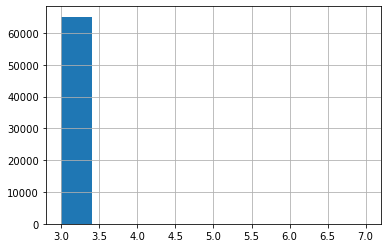

In [164]:
for_predict_df_prod['catBoost'].hist()

In [167]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            name_feature != 'BK' and
             name_feature != 'GR' and
             name_feature != 'LIT' and
             name_feature != 'NKTB' and
            name_feature != 'SP' and
            name_feature != 'AGR' and
            name_feature != 'ASP' and
            name_feature != 'ANK' and
            name_feature != 'catBoost' and 
            name_feature != 'random' and 
            name_feature != 'catBoost_prod_39' and 
            name_feature != 'catBoost_prod_52' and 
            name_feature != 'catBoost_prod_152' and
            name_feature != 'catBoost_prod_100' and
            name_feature != 'all' and
            name_feature != 'KNeighborsClassifier_1' and
            name_feature != 'KNeighborsClassifier_1_log'
           ):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('predict_7_facies_experiment_start_interval_1.csv', index=False)
    
save(for_predict_df_prod)

GR_last_lag_1
GR_last_lag_10
GR_last_lag_13
GR_last_lag_16
GR_last_lag_19
GR_last_lag_22
GR_last_lag_25
GR_last_lag_28
GR_last_lag_4
GR_last_lag_7
GR_next_lag_1
GR_next_lag_10
GR_next_lag_13
GR_next_lag_16
GR_next_lag_19
GR_next_lag_22
GR_next_lag_25
GR_next_lag_28
GR_next_lag_4
GR_next_lag_7
